In [119]:
import os
import imageio

import sys
import cv2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
import seaborn as sns

import keras
import json

In [120]:
data_path='v2-plant-seedlings-dataset'

In [121]:
print(os.listdir(data_path)) # list of all folders or classes

['Cleavers', '.DS_Store', 'Sugar beet', 'Common Chickweed', 'Loose Silky-bent', 'Scentless Mayweed', 'Shepherd’s Purse', 'Fat Hen', 'Common wheat', 'Black-grass', 'Small-flowered Cranesbill', 'Charlock', 'Maize']


In [ ]:
images = []
classes=[]
missing=0
for class_folder_name in os.listdir(data_path):
    class_folder_path = os.path.join(data_path, class_folder_name)
    class_label = class_folder_name
    
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)

        if image_bgr is None: # if the file contain any missig value ignore it
            missing += 1
            continue
        images.append(image_bgr)
        classes.append(class_label)

In [ ]:
def resize_images(img, shape=(256, 256), interp = cv2.INTER_CUBIC):
    img = np.array(img).astype(np.uint8)
    res = cv2.resize(img, shape, interpolation = interp)
    return res

In [ ]:
images = [resize_images(img) for img in images]

In [7]:
images[0].shape


(256, 256, 3)

In [8]:
#see number of images in each lablel
images = np.array(images)
classes = np.array(classes)
print("images shape: ", images.shape)
print("classes shape: ", classes.shape)
#for key,value in images_per_class.items():
   # print("number of {0} images is  -> {1}".format(key, len(value)))
  
for label in set(classes):

  print("number of {} images is  -> {}".format(
        label, 
        len(images[classes == label])))


images shape:  (5539, 256, 256, 3)
classes shape:  (5539,)
number of Charlock images is  -> 452
number of Sugar beet images is  -> 463
number of Common wheat images is  -> 253
number of Cleavers images is  -> 335
number of Common Chickweed images is  -> 713
number of Shepherd’s Purse images is  -> 274
number of Loose Silky-bent images is  -> 762
number of Fat Hen images is  -> 538
number of Small-flowered Cranesbill images is  -> 576
number of Maize images is  -> 257
number of Scentless Mayweed images is  -> 607
number of Black-grass images is  -> 309


In [9]:
values =[]
labels=[]
for label in set(classes):
  values.append(len(images[classes == label]))
  labels.append(label)

# fig, ax = plt.subplots(figsize=(22,7))
# ax.bar(labels, values)
# ax.set_xlabel(" classes")
# ax.set_ylabel("number of images")
# #axs[1].scatter(label, )
#   #axs[2].plot(names, values)
# fig.suptitle('Categorical Plotting')


In [11]:
def plot_for_class(label):
    nb_rows = 2
    nb_cols = 2
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))
    class_images =images[classes== label]
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(class_images[n])
            n += 1 
#plot_for_class("Scentless Mayweed")


In [32]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [33]:
def segment(img):

  #image_mask = create_mask_for_plant(img)
  image_segmented = segment_plant(img)
  image_sharpen = sharpen_image(image_segmented)
  return image_sharpen

In [34]:
a_images = images

for indx, image in enumerate(images):
  try:
     images[indx] = segment(image)
      
  except:
    print(indx)
    continue

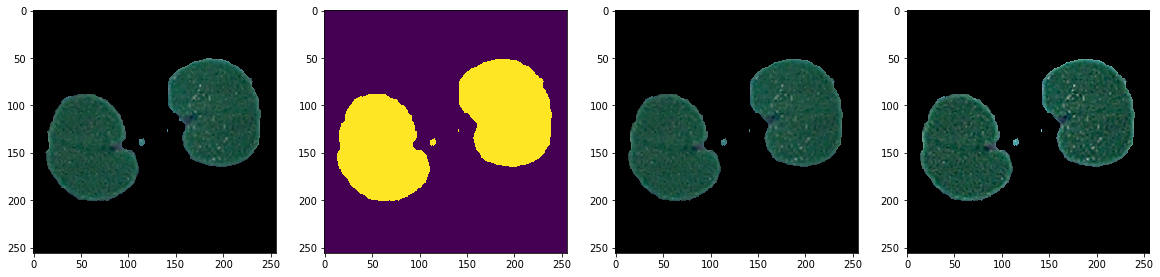

In [35]:
 image = images[classes == "Small-flowered Cranesbill"][40]
 a_image = a_images[classes == "Small-flowered Cranesbill"][40]
  
 image_mask = create_mask_for_plant(image)
 image_segmented = segment_plant(image)
 image_sharpen = sharpen_image(image_segmented)

 fig, axs = plt.subplots(1, 4, figsize=(20, 20))
 axs[0].imshow(a_image)
 axs[1].imshow(image_mask)
 axs[2].imshow(image_segmented)
 axs[3].imshow(image_sharpen)

In [36]:
images.shape

(5539, 256, 256, 3)

In [37]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y = enc.fit_transform(classes)

In [38]:
y[0]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [107]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.3, random_state=50)

In [108]:
X_train.shape

(5, 256, 256, 3)

In [109]:
random_seed = 2
from sklearn.model_selection import train_test_split
X_test, X_val, y_test, Y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=random_seed)


In [110]:
print(X_test.shape)
print(X_val.shape)

(5528, 256, 256, 3)
(6, 256, 256, 3)


In [115]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

# Set the CNN model 

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))


batch_size = None

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', batch_input_shape = (batch_size,256, 256, 3)))


model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.4))
model.add(GlobalMaxPooling2D())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(12, activation = "softmax"))
model.summary()

lr = 0.001

opt = Adam(lr)

optimizer = RMSprop(lr, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 256, 256, 32)      2432      
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 256, 256, 32)      25632     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_61 (Dropout)         (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 64, 64, 64)        0         
__________

In [118]:
history1 = model.fit(X_train, y_train, epochs = 100, validation_data = (X_val,Y_val),batch_size = batch_size, callbacks=[history])

filename = f'DlLr{lr}Cl'
saveFolderName = os.path.join(filename)

savePath = os.path.join(os.getcwd(),saveFolderName)
print("Saving C.history in " + savePath + "\n")
if not os.path.exists(savePath):
    os.makedirs(savePath)

with open(os.path.join(savePath,('history.json')) , 'w+') as f:
    json.dump(history1.history, f)


Train on 5 samples, validate on 6 samples
Epoch 1/1
5/5 [==============================] - 5s 1s/step - loss: 16.1181 - acc: 0.0000e+00 - val_loss: 13.1383 - val_acc: 0.1667
Saving C.history in /Users/raghav/Downloads/DlLr0.001Cl



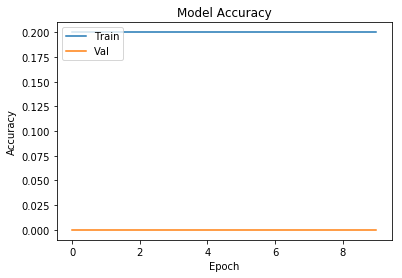

In [83]:
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

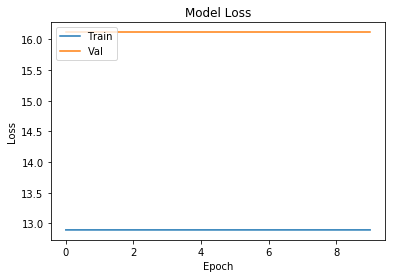

In [84]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()